In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/My Drive/NNFL_data/FCN-for-Semantic-Segmentation
Path_to_weights = '/content/drive/My Drive/NNFL_data/pascal-fcn16s-dag.mat'
PATH_TO_train_txt = '/content/drive/My Drive/NNFL_data/My_model/train.txt'

/content/drive/My Drive/NNFL_data/FCN-for-Semantic-Segmentation


In [0]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

from scipy.io import loadmat

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

from skimage.io import imread, imsave
import copy
import math

image_size = 512

Using TensorFlow backend.


In [0]:
data = loadmat(Path_to_weights, matlab_compatible=False, struct_as_record=False)
layers = data['layers']
params = data['params']
description = data['meta'][0,0].classes[0,0].description

In [0]:
for i in range(0, params.shape[1]-1, 2):
    print(i,
          str(params[0,i].name[0]), params[0,i].value.shape,
          str(params[0,i+1].name[0]), params[0,i+1].value.shape)

0 conv1_1_filter (3, 3, 3, 64) conv1_1_bias (64, 1)
2 conv1_2_filter (3, 3, 64, 64) conv1_2_bias (64, 1)
4 conv2_1_filter (3, 3, 64, 128) conv2_1_bias (128, 1)
6 conv2_2_filter (3, 3, 128, 128) conv2_2_bias (128, 1)
8 conv3_1_filter (3, 3, 128, 256) conv3_1_bias (256, 1)
10 conv3_2_filter (3, 3, 256, 256) conv3_2_bias (256, 1)
12 conv3_3_filter (3, 3, 256, 256) conv3_3_bias (256, 1)
14 conv4_1_filter (3, 3, 256, 512) conv4_1_bias (512, 1)
16 conv4_2_filter (3, 3, 512, 512) conv4_2_bias (512, 1)
18 conv4_3_filter (3, 3, 512, 512) conv4_3_bias (512, 1)
20 conv5_1_filter (3, 3, 512, 512) conv5_1_bias (512, 1)
22 conv5_2_filter (3, 3, 512, 512) conv5_2_bias (512, 1)
24 conv5_3_filter (3, 3, 512, 512) conv5_3_bias (512, 1)
26 fc6_filter (7, 7, 512, 4096) fc6_bias (4096, 1)
28 fc7_filter (1, 1, 4096, 4096) fc7_bias (4096, 1)
30 score_fr_filter (1, 1, 4096, 21) score_fr_bias (21, 1)
32 score2_filter (4, 4, 21, 21) score2_bias (21, 1)
34 score_pool4_filter (1, 1, 512, 21) score_pool4_bias (21,

In [0]:
# Function to create to a series of CONV layers followed by Max pooling layer
def Convblock(channel_dimension, block_no, no_of_convs) :
    Layers = []
    for i in range(no_of_convs) :
        
        Conv_name = "conv"+str(block_no)+"_"+str(i+1)
        
        # A constant kernel size of 3*3 is used for all convolutions
        Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))
    
    Max_pooling_name = "pool"+str(block_no)
    
    #Addding max pooling layer
    Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))
    
    return Layers
  

#Helper function to create Sequential part of the Architecture
def FCN_16_helper(image_size):
    model = Sequential()
    model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))
     
    for l in Convblock(64,1,2) :
        model.add(l)
    
    for l in Convblock(128,2,2):
        model.add(l)
    
    for l in Convblock(256,3,3):
        model.add(l)
    
    for l in Convblock(512,4,3):
        model.add(l)
    
    for l in Convblock(512,5,3):
        model.add(l)
    
    
    model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))
    
    #Replacing fully connnected layers of VGG Net using convolutions
    model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))
      
    # Gives the classifications scores for each of the 21 classes including background
    model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))
        
    Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
    print(Conv_size)
    
    model.add(Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))
    
    
    #Cropping to get correct size
    model.add(Cropping2D(cropping=((0,2),(0,2))))
    return model


    
def FCN_16(image_size) :
    fcn_16 = FCN_16_helper(512)
    
    #Calculating conv size after the sequential block
    #32 if image size is 512*512
    Conv_size = fcn_16.layers[-1].output_shape[2] 
    
    skip_con = Convolution2D(21,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")
    
    #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
    Summed = add(inputs = [skip_con(fcn_16.layers[14].output),fcn_16.layers[-1].output])
    
    
    Up = Deconvolution2D(21,kernel_size=(32,32),strides = (16,16),padding = "valid",activation = None,name = "upsample_new")
    
    #528 if image size is 512*512
    Deconv_size = (Conv_size-1)*16+32
    
    #16 if image size is 512*512
    extra_margin = (Deconv_size - Conv_size*16)
    
    #Cropping to get the original size of the image
    crop = Cropping2D(cropping = ((0,extra_margin),(0,extra_margin)))
    return Model(fcn_16.input, crop(Up(Summed)))

fcn16_model = FCN_16(512)
print(fcn16_model.summary())





16
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 512, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 512, 512, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 512, 512, 64) 36928       conv1_1[0][0]                    
_____________________________________________________________________________________

In [0]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, params.shape[1]-1, 2):
        matname = '_'.join(params[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = params[0,i].value
            l_bias = params[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [0]:
copy_mat_to_keras(fcn16_model)

found :  ('conv1_1', 2)






(3, 3, 3, 64) (3, 3, 3, 64)
found :  ('conv1_2', 3)
(3, 3, 64, 64) (3, 3, 64, 64)
found :  ('conv2_1', 5)
(3, 3, 64, 128) (3, 3, 64, 128)
found :  ('conv2_2', 6)
(3, 3, 128, 128) (3, 3, 128, 128)
found :  ('conv3_1', 8)
(3, 3, 128, 256) (3, 3, 128, 256)
found :  ('conv3_2', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv3_3', 10)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv4_1', 12)
(3, 3, 256, 512) (3, 3, 256, 512)
found :  ('conv4_2', 13)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv4_3', 14)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_1', 16)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_2', 17)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_3', 18)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('fc6', 20)
(7, 7, 512, 4096) (7, 7, 512, 4096)
found :  ('fc7', 21)
(1, 1, 4096, 4096) (1, 1, 4096, 4096)
found :  ('score_fr', 22)
(1, 1, 4096, 21) (1, 1, 4096, 21)
found :  ('score2', 23)
(4, 4, 21, 21) (4, 4, 21, 21)
found :  ('scor

In [0]:
def crop_image(path, image_size = 512):
  im = Image.open(path) 
  im = im.crop((0,0,319,319)) # WARNING : manual square cropping
  im = im.resize((image_size,image_size))
  return im
  
  
def prediction(kmodel, path, image_size = 512):
	
  crpimg = crop_image(path, image_size)
  imarr = np.array(crpimg).astype(np.float32)
  imarr = np.expand_dims(imarr, axis=0)
  return kmodel.predict(imarr)

def save_prediction(preds, path) :
  imclass = np.argmax(preds, axis=3)[0,:,:]
  #imageio.imwrite(path, imclass)
  np.save(path, imclass)
  


def show_prediction(im_path, preds, image_size = 512) :
  imclass = np.argmax(preds, axis=3)[0,:,:]
  crpimg = crop_image(im_path, image_size)
  

  plt.figure(figsize = (15, 7))
  plt.subplot(1,3,1)
  plt.imshow(np.asarray(crpimg))
  plt.subplot(1,3,2)
  plt.imshow(imclass) 
  plt.subplot(1,3,3)
  plt.imshow(np.asarray(crpimg))
  masked_imclass = np.ma.masked_where(imclass == 0, imclass)
  plt.imshow( masked_imclass, alpha=0.5 )
 
 

In [0]:
text_file = open(PATH_TO_train_txt, "r")
lines = text_file.read().split('\n')
lines = np.array(lines)
lines = lines[0:-1]
lines.shape, lines[-1], lines[-2]

((1464,), '2011_003255', '2011_003246')

In [0]:
for i in lines :
  print(i)
  preds = prediction(fcn16_model, '/content/drive/My Drive/NNFL_data/pascal_data_train_val/Seg_jpeg_train/'+i+'.jpg') 
  save_prediction(preds,'predictions_16/'+i+'.npy')

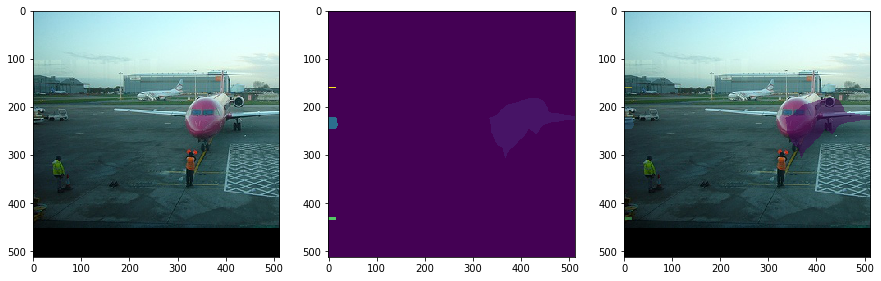

In [0]:
preds = prediction(fcn16_model, 'TestImages/2007_000032.jpg') 
show_prediction('TestImages/2007_000032.jpg' , preds) 

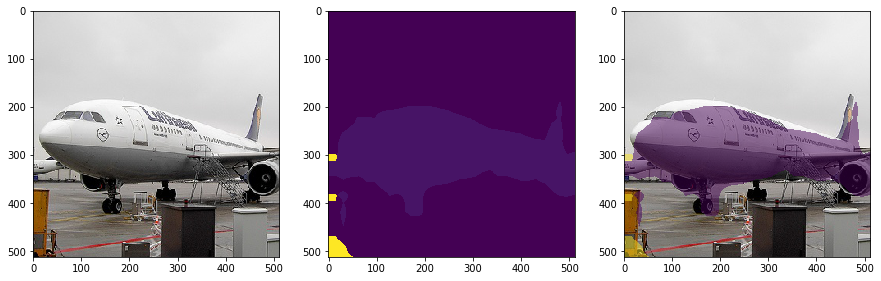

In [0]:
preds = prediction(fcn16_model, 'TestImages/2007_000033.jpg') 
show_prediction('TestImages/2007_000033.jpg', preds) 

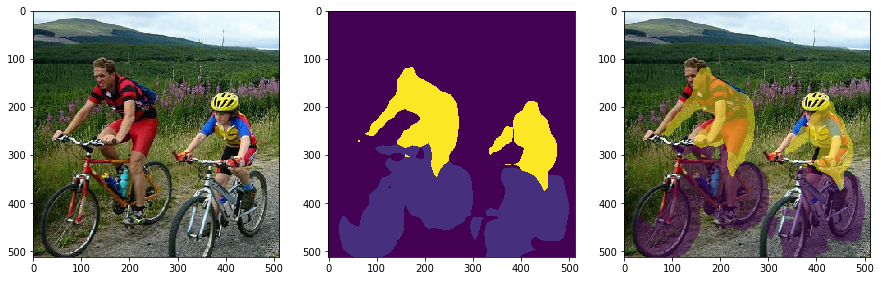

In [0]:
preds = prediction(fcn16_model, 'TestImages/rgb.jpg') 
show_prediction('TestImages/rgb.jpg', preds) 

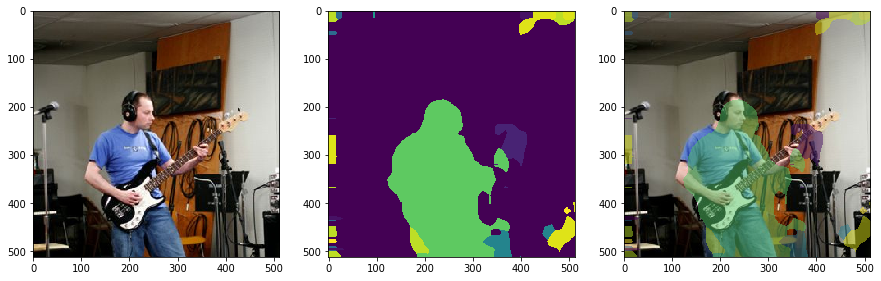

In [0]:
preds = prediction(fcn16_model, 'TestImages/2012_003255.jpg') 
show_prediction('TestImages/2012_003255.jpg', preds) 

In [0]:
pa = []
ma = []
miu = []
fwiu = []

for i in lines:
    print(i)
    im = Image.open('/content/drive/My Drive/NNFL_data/pascal_data_train_val/Seg_png_train/' + i +'.png')
    im = im.crop((0,0,319,319))
    im = im.resize((512,512))
    y_true = np.array(im)    
    y_pred =  np.load('predictions_16/'+i+'.npy')
    
    pa.append(pixel_accuracy(y_pred, y_true))
    ma.append(mean_accuracy(y_pred, y_true))
    miu.append(mean_IU(y_pred, y_true))
    fwiu.append(frequency_weighted_IU(y_pred, y_true))
    

2007_000032
2007_000039
2007_000063
2007_000068
2007_000121
2007_000170
2007_000241
2007_000243
2007_000250
2007_000256
2007_000333
2007_000363
2007_000364
2007_000392
2007_000480
2007_000504
2007_000515
2007_000528
2007_000549
2007_000584
2007_000645
2007_000648
2007_000713
2007_000720
2007_000733
2007_000738
2007_000768
2007_000793
2007_000822
2007_000836
2007_000876
2007_000904
2007_001027
2007_001073
2007_001149
2007_001185
2007_001225
2007_001340
2007_001397
2007_001416
2007_001420
2007_001439
2007_001487
2007_001595
2007_001602
2007_001609
2007_001698
2007_001704
2007_001709
2007_001724
2007_001764
2007_001825
2007_001834
2007_001857
2007_001872
2007_001901
2007_001917
2007_001960
2007_002024
2007_002055
2007_002088
2007_002099
2007_002105
2007_002107
2007_002120
2007_002142
2007_002198
2007_002212
2007_002216
2007_002227
2007_002234
2007_002273
2007_002281
2007_002293
2007_002361
2007_002368
2007_002370
2007_002403
2007_002462
2007_002488
2007_002545
2007_002611
2007_002639
2007

In [0]:
pa = np.array(pa)
ma = np.array(ma)
miu = np.array(miu)
fwiu = np.array(fwiu)

pa.shape, ma.shape, miu.shape, fwiu.shape

((1464,), (1464,), (1464,), (1464,))

In [0]:
print(np.mean(pa))
print(np.mean(ma))
print(np.mean(miu))
print(np.mean(fwiu))

0.7705638082952447
0.4602474899794652
0.38191074904522876
0.6759099615065374


In [0]:
import numpy as np

def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)

    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)

        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)

    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)

    sum_k_t_k = get_pixel_area(eval_segm)

    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)
